In [1]:
from matplotlib import pylab as plt
from sklearn.metrics import mean_squared_error
from itertools import compress
import xml.etree.ElementTree as ET
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from ase.geometry.analysis import Analysis
from ase.geometry import cellpar_to_cell

from tqdm.notebook import tqdm


from time import time
import rascal
import json
import math

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
from ase.geometry import wrap_positions
import numpy as np

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.models.asemd import ASEMLCalculator
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score, FPSFilter

In [ ]:
'''
This file is used to plot the RDFs and energy distributions of the frames from
the phosphorus allotropes data set.
'''

In [2]:
# All functions used are defined in this cell

def extract_ref(frames,energy_key=True,number_key=True):
    e,n = [], []
    for frame in frames:
        if energy_key:
            e.append(frame.info['energy'])
        if number_key:
            n.append(len(frame))        
    e = np.array(e)
    n = np.array(n)
    return e,n

def extend_cell(frame,r_cut):
    
    vec_cell = frame.cell.cellpar()
    M1, M2, M3 = vec_cell[0]**2, vec_cell[1]**2, vec_cell[2]**2
    M12 = vec_cell[0]*vec_cell[1]*np.cos(vec_cell[5]*np.pi/180)
    M13 = vec_cell[0]*vec_cell[2]*np.cos(vec_cell[4]*np.pi/180)
    M23 = vec_cell[1]*vec_cell[2]*np.cos(vec_cell[3]*np.pi/180)
    det_M = M1*M2*M3-M1*M23**2-M2*M13**2-M3*M12**2+2*M12*M13*M23
    N1=math.ceil(np.sqrt((M2*M3-M23**2)/det_M)*r_cut)
    N2=math.ceil(np.sqrt((M1*M3-M13**2)/det_M)*r_cut)
    N3=math.ceil(np.sqrt((M1*M2-M12**2)/det_M)*r_cut)
    
    pbc = frame.get_pbc()
    
    cell_size = [(2*N1+1) if pbc[0] else 1,
                  (2*N2+1) if pbc[1] else 1, 
                  (2*N3+1) if pbc[2] else 1]
    return cell_size

def plot_ave_rdf(frames,r=6.,bins=100,key=None):
    
    '''
    
    This function is used to calculate the average rdf per atom!
    
    frames: all the frames where we want to calculate the average rdf
    r: the cutoff distance
    bins: number of points
    
    '''
    
    frames2=frames
    n=len(frames)
    ave_rdf=np.zeros(bins)
    
    for frame in frames2:
        try:
            ana=Analysis(frame)
            rdf=ana.get_rdf(r,bins, return_dists=True)
        except:
            cell_size = extend_cell(frame, r)
            frame*=(cell_size[0],cell_size[1],cell_size[2])
            ana=Analysis(frame)
            rdf=ana.get_rdf(r,bins, return_dists=True)
        ave_rdf+=rdf[0][0]
    
    ave_rdf=ave_rdf/n
    
    x=(np.linspace(0,r,bins+1)[1:]+np.linspace(0,r,bins+1)[:-1])/2
    
    plt.figure()
    plt.plot(x,ave_rdf)
    plt.xlabel('Radius (Angstrom)',fontsize='x-large')
    if key is not None:
        plt.ylabel('RDF of '+str(key),fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks([])

    
    if key == 'P2/P4':
        plt.savefig('./RDF/RDF_P2-P4.png'.format(key),format='png')
    else:
        plt.savefig('./RDF/RDF_{}.png'.format(key),format='png')
    
    plt.show()
    plt.close()

In [3]:
N = 4798
frames = read('P_GAP_20_fitting_data.xyz', index=':{}'.format(N))

for frame in frames:
    frame.set_positions(wrap_positions(frame.get_positions(),frame.get_cell(),eps=1e-10))

dataset={'P2/P4':[]}
for i in range(N):
    try:
        name=frames[i].info['config_type']
        if name in dataset:
            dataset[name].append(i)
        else:
            dataset[name]=[i]
    except:
        dataset['P2/P4'].append(i)
for key in dataset.keys():
    print('Number of frames in '+str(key)+" : "+str(len(dataset[key])))


print(' ')
### check if we have considered all frames

idxs=list(dataset.values())
n_keys=len(dataset.keys())
checklist=[]
status=True

for i in range(n_keys):
    checklist+=idxs[i]
    
for i in range(N):
    if i in checklist:
        pass
    elif i not in checklist:
        print('Warning: missed frame: '+str(i))
        status=False
if status:
    print('All frames are checked!')
    
print(dataset['isolated_atom'])
print(frames[4795].get_total_energy())

Number of frames in P2/P4 : 35
Number of frames in liq_12_03_01_liqP4 : 88
Number of frames in liq_12_03_02_network : 164
Number of frames in phosphorene : 87
Number of frames in phosphorus_ribbons : 40
Number of frames in rss_3c : 400
Number of frames in cryst_dist : 959
Number of frames in 2D : 1234
Number of frames in rss_200 : 596
Number of frames in rss_005 : 995
Number of frames in rss_rnd : 199
Number of frames in isolated_atom : 1
 
All frames are checked!
[4795]
-0.09753304


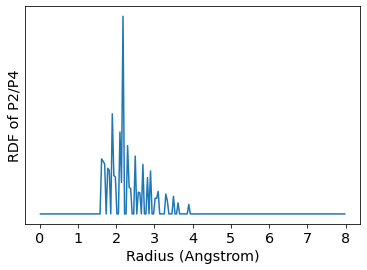

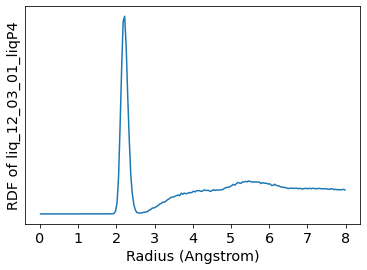

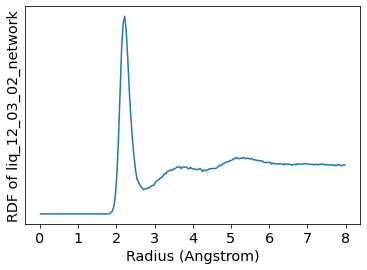

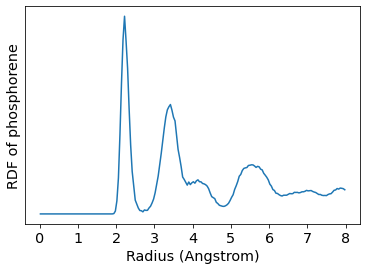

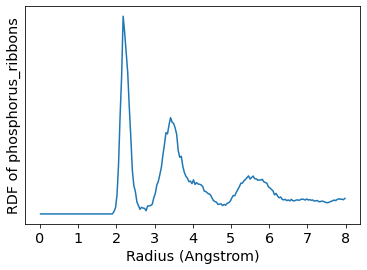

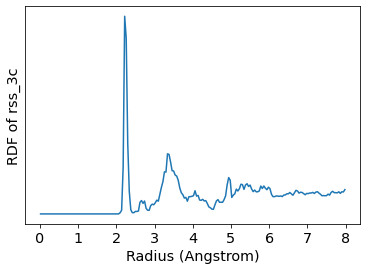

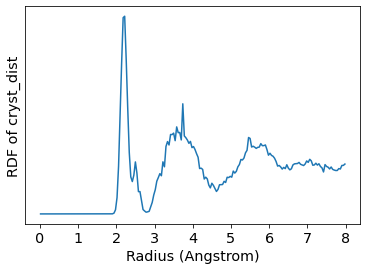

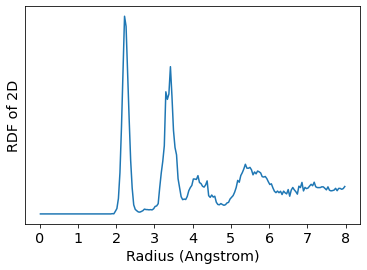

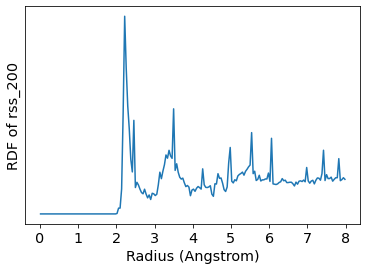

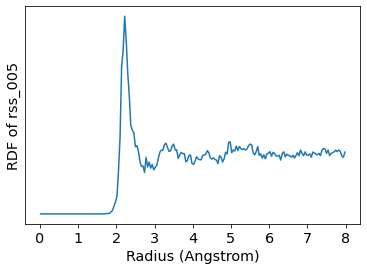

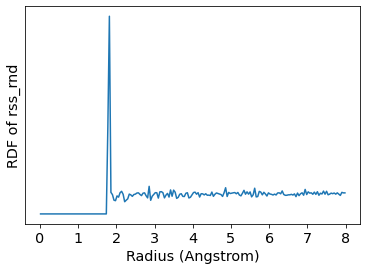

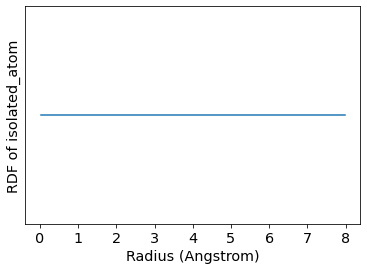

In [56]:
### For each category, we plot the average rdf

for key in dataset.keys():
    frames_temp = [frames[i] for i in dataset[key]]
    plot_ave_rdf(frames_temp,r=8.,bins=200,key=key)

Standard energy deviation of subset P2/P4:
1.083762217298512 eV/atom

Standard energy deviation of subset liq_12_03_01_liqP4:
0.009957006706321042 eV/atom

Standard energy deviation of subset liq_12_03_02_network:
0.11134889298522323 eV/atom

Standard energy deviation of subset phosphorene:
0.04054449496220119 eV/atom

Standard energy deviation of subset phosphorus_ribbons:
0.058685260908506565 eV/atom

Standard energy deviation of subset rss_3c:
0.10298455550222223 eV/atom

Standard energy deviation of subset cryst_dist:
0.15131582862582063 eV/atom

Standard energy deviation of subset 2D:
0.12964669363624048 eV/atom

Standard energy deviation of subset rss_200:
0.22372269090038105 eV/atom

Standard energy deviation of subset rss_005:
0.2685173851685735 eV/atom

Standard energy deviation of subset rss_rnd:
0.802550088209301 eV/atom

Standard energy deviation of subset isolated_atom:
0.0 eV/atom



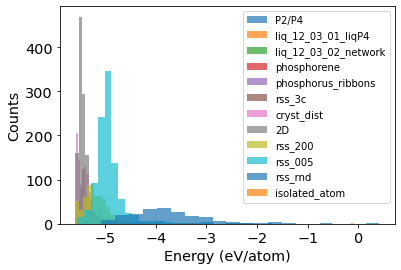

In [7]:
### Energy distribution

plt.figure()
for key in dataset.keys():
    frames_temp = [frames[i] for i in dataset[key]]
    e_temp, n_temp = extract_ref(frames_temp, True, True)
    e_temp_atom = e_temp/n_temp
    print('Standard energy deviation of subset '+str(key)+":")
    print(str(e_temp_atom.std())+' eV/atom')
    print('')
    plt.hist(e_temp_atom, bins=20,label=key,alpha=0.7)

#plt.xlim(-5.6,-4)
plt.xlabel('Energy (eV/atom)',fontsize='x-large')
plt.ylabel('Counts',fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.legend()
plt.savefig('./energy_deviation/e_dev.png')
plt.show()

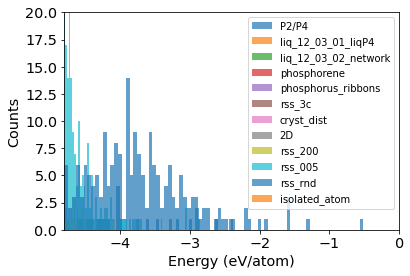

In [10]:
### Normalized energy distribution

plt.figure()
for key in dataset.keys():
    frames_temp = [frames[i] for i in dataset[key]]
    e_temp, n_temp = extract_ref(frames_temp, True, True)
    e_temp_atom = e_temp/n_temp
    count = len(dataset[key])
    e_norm = e_temp_atom
    plt.hist(e_temp_atom, bins=100,label=key,alpha=0.7)

plt.xlim(-4.8,-0.0)
plt.ylim(0,20)
plt.xlabel('Energy (eV/atom)',fontsize='x-large')
plt.ylabel('Counts',fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.legend()
plt.savefig('./energy_deviation/e_dev_zoom.png')
plt.show()